In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.autograd import Variable 
from typing import Tuple, Dict, List
from torch.optim import lr_scheduler
import pathlib
import os
import requests
import zipfile
from pathlib import Path
import random
from tqdm.auto import tqdm

In [3]:
import pandas as pd  # pip install pandas
from numpy import array
from os import listdir
from os.path import isfile, join
from datetime import datetime
import time
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from numpy import array
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
data = pd.read_csv('/notebooks/CSVs/data_h1.csv')

In [6]:
data = data.drop(['time', 'Label'], axis=1)

In [7]:
len(data.columns)

18

In [8]:
data_train_sc = data[:85000]
data_val_sc = data[85000:120000]
data_test_sc = data[120000:]

In [9]:
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train_sc)
data_val = scaler.transform(data_val_sc)
data_test = scaler.transform(data_test_sc)

In [10]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data    
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(train):
            X.append(train[in_start:in_end, :])
            y.append(train[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [11]:
n_input=400
n_out=3
data_train_X, data_train_y = to_supervised(data_train, n_input=n_input, n_out=n_out)
data_val_X, data_val_y = to_supervised(data_val, n_input=n_input, n_out=n_out)
data_test_X, data_test_y = to_supervised(data_test, n_input=n_input, n_out=n_out)

In [12]:
data_train_X.shape, data_train_y.shape

((84597, 400, 18), (84597, 3))

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df_x, df_y):
        self.data_x = df_x         
        self.data_y = df_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, index):
        feature = torch.from_numpy(self.data_x[index]).float()
        label = torch.from_numpy(np.asarray(self.data_y[index])).float()
        #label = label.type(torch.LongTensor)
        return feature, label

In [14]:
train_dataset = CustomDataset(data_train_X, data_train_y)
val_dataset = CustomDataset(data_val_X, data_val_y)
test_dataset = CustomDataset(data_test_X, data_test_y)

In [15]:
batch_size=32

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa4eafbf5b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa4eafbf520>)

In [17]:
feature, label = next(iter(train_dataloader))

In [18]:
feature.shape, label.shape

(torch.Size([32, 400, 18]), torch.Size([32, 3]))

In [47]:
from torch import nn
from torch.nn import functional as F

num_epochs = 20 
lr = 0.1
n_features = 18 
hidden_dim = 128 
n_layers = 2

class LSTM1(nn.Module):
    def __init__(self):
        super(LSTM1, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, 16)
        self.linear2 = nn.Linear(16, 3)
        #self.linear3 = nn.Linear(32, 3)
        self.dropout = nn.Dropout(p=0.3)
        self.hidden_dim = hidden_dim
        self.device = device
        self.BatchNorm = nn.BatchNorm1d(32, affine=False)
        self.relu = nn.ReLU()

    def forward(self, X_batch):
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim).to(self.device), torch.randn(n_layers, len(X_batch), hidden_dim).to(self.device)
        hidden = self.BatchNorm(hidden)
        carry = self.BatchNorm(carry)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))        
        out = self.linear1(output[:,-1])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)        
        # out = self.relu(out)
        # out = self.dropout(out)
        # out = self.linear3(out)
        return out

In [48]:
# class LSTM1(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, device):
#         super(LSTM1, self).__init__()
#         self.device = device
#         # self.num_classes = num_classes #number of classes
#         self.num_layers = num_layers #number of layers
#         self.input_size = input_size #input size
#         self.hidden_size = hidden_size #hidden state        
#         self.BatchNorm = nn.BatchNorm1d(32, affine=False)

#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                           num_layers=num_layers, batch_first=True) #lstm        
#         self.fc_1 =  nn.Linear(hidden_size, 64) #fully connected 1
#         self.fc_2 =  nn.Linear(64, 32) #fully connected 1
#         self.fc = nn.Linear(32, 2) #fully connected last layer
#         self.dropout = nn.Dropout(p=0.5)
#         self.relu = nn.ReLU()
    
#     def forward(self,x):
#         h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #hidden state Variable(
#         c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #internal state Variable(
#         h_0 = self.BatchNorm(h_0)
#         c_0 = self.BatchNorm(c_0)
#         # Propagate input through LSTM
#         output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state        
#         hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)        
#         out = self.fc_1(out) #first Dense
#         out = self.relu(out) #relu
#         # out = self.dropout(out)
#         out = self.fc_2(out) #first Dense
#         out = self.relu(out) #relu
#         out = self.dropout(out)
#         out = self.fc(out) #Final Output
#         return out

In [49]:
model = LSTM1() # input_size, hidden_size, num_layers, device
model.to(device)
print(model)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[3,5,8,11,14,20,25], gamma=0.1)

LSTM1(
  (lstm): LSTM(18, 128, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (BatchNorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (relu): ReLU()
)


In [50]:
for layer in model.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : LSTM(18, 128, num_layers=2, batch_first=True)
Parameters : 
torch.Size([512, 18])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])

Layer : Linear(in_features=128, out_features=16, bias=True)
Parameters : 
torch.Size([16, 128])
torch.Size([16])

Layer : Linear(in_features=16, out_features=3, bias=True)
Parameters : 
torch.Size([3, 16])
torch.Size([3])

Layer : Dropout(p=0.3, inplace=False)
Parameters : 

Layer : BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
Parameters : 

Layer : ReLU()
Parameters : 



In [51]:
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.functional import precision_recall

In [52]:
import torch
import shutil
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler: lr_scheduler.MultiStepLR,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)         

        # 3. Optimizer zero grad
        optimizer.zero_grad()        

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
      
    return train_loss

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
   
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    val_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(dataloader)
    
    return val_loss

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: lr_scheduler.MultiStepLR,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
   
    # Create empty results dictionary
    results = {"train_loss": [],               
               "val_loss": []               
    }
    
    # Make sure model on target device
    model.to(device)
    # best_loss = 3.0
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        
        train_loss = train_step(model=model,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              scheduler=scheduler,
                              device=device)
        val_loss = test_step(model=model,
                              dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              device=device)
        
        PATH = f'/notebooks/models/model_{epoch+1}.pth'
        # if val_loss < best_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': loss_fn,
            }, PATH)
            # best_loss = val_loss
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "          
          f"val_loss: {val_loss:.4f} | "          
        )
        

        # Update results dictionary
        results["train_loss"].append(train_loss)        
        results["val_loss"].append(val_loss)        

    # Return the filled results at the end of the epochs
    return results

In [53]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                   train_dataloader=train_dataloader,
                   val_dataloader=val_dataloader,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   loss_fn=loss_fn,
                   epochs=num_epochs,
                   device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3420 | val_loss: 0.2848 | 
Epoch: 2 | train_loss: 0.3336 | val_loss: 0.2848 | 
Epoch: 3 | train_loss: 0.3336 | val_loss: 0.2848 | 


KeyboardInterrupt: 

In [309]:
# Get a set of pretrained model weights
model_load = LSTM1()
model_load.to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

PATH = "/notebooks/models/model_8.pth"
checkpoint = torch.load(PATH)
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# # Set the random seeds
# torch.manual_seed(17)
# torch.cuda.manual_seed(17)

# # Start the timer
# from timeit import default_timer as timer 
# start_time = timer()

# # Setup training and save the results
# results = train(model=model_load,
#                    train_dataloader=train_dataloader,
#                    val_dataloader=val_dataloader,
#                    optimizer=optimizer,
#                    loss_fn=loss_fn,
#                    epochs=num_epochs,
#                    device=device)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [352]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)            
            preds = outputs[1]
            labels = labels[1]
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [353]:
y_pred, y_test = get_predictions(model, test_dataloader)

In [354]:
a = y_test.detach().numpy().squeeze().tolist()

In [355]:
b = y_pred.detach().numpy().squeeze().tolist()

In [356]:
df = pd.DataFrame({'Test': a,
                   'Preds': b
                  })

In [357]:
df_0 = df[:150]

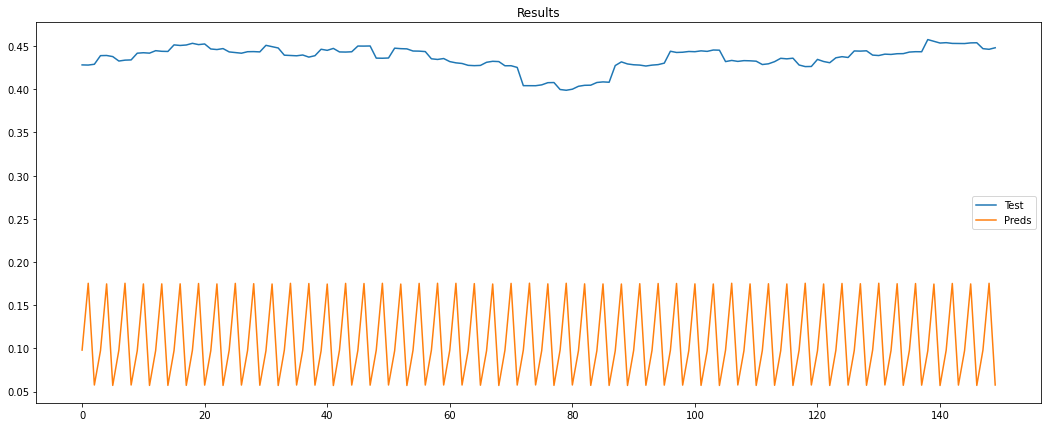

In [359]:
df_0.plot(y=["Test", "Preds"],figsize=(18,7));# 
plt.title('Results', loc='center');
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black');

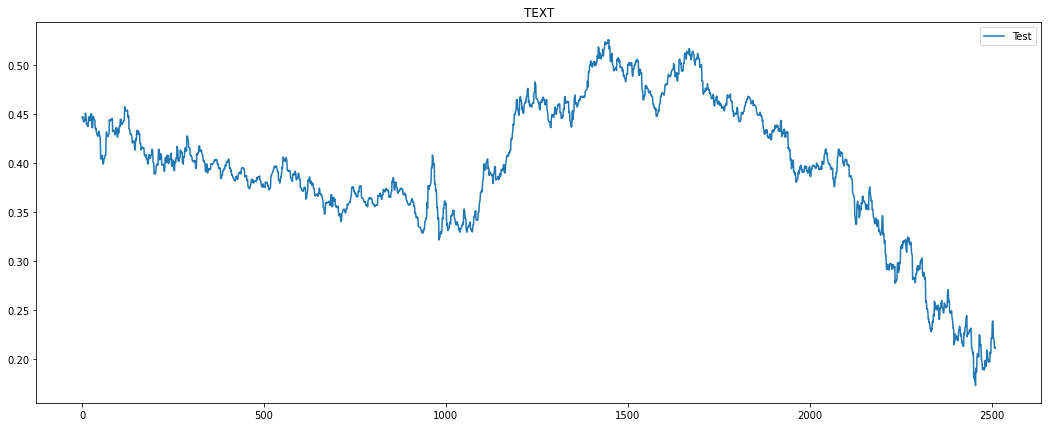

In [319]:
df.plot(y=["Test"],figsize=(18,7)); #, "Preds"
plt.title('TEXT', loc='center')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black');